"""
Author: Himaja R. Ginkala
Description: Compares multiple deep learning models for classifying benign and malignant skin cancer images.
"""

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision.models as models
from torchvision import datasets, transforms

from data_loader import load_data
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

In [ ]:
# load data
train_loader, val_loader, test_loader, train_dataset = load_data(batch_size=32)

### Model Definitions

In [70]:
models_to_compare = [
    {
        'name': 'ResNet-18',
        'model': models.resnet18(pretrained=True),
        'num_features': lambda model: model.fc.in_features,
    }
]

### Model Execution

In [71]:
EPOCHS = 5
LEARNING_RATE = 0.001

In [72]:
for model_info in models_to_compare:
    model_name = model_info['name']
    model = model_info['model']

    # modify final layer to match number of classes
    num_features = model_info['num_features'](model)
    model.fc = nn.Linear(num_features, 2)

    # move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # training loop
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model.train()
        running_train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS} - {model_name}', leave=True)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
            # compute loss
            loss = criterion(outputs, labels)
            # backward pass
            loss.backward()
            # update weights
            optimizer.step()

            # update training loss
            running_train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix(loss=f'{running_train_loss / len(train_loader.dataset):.4f}')
        
        # average training loss for epoch
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        #  set model to evaluation mode
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        # average validation loss for epoch
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    # testing
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f'Testing - {model_name}', leave=True):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2%}")



Epoch 1/5 - ResNet-18:   0%|          | 0/297 [00:00<?, ?it/s]Epoch 1/5 - ResNet-18: 100%|██████████| 297/297 [14:08<00:00,  2.86s/it, loss=0.3568]


Epoch 1/5, Train Loss: 0.3568, Val Loss: 0.2934


Epoch 2/5 - ResNet-18: 100%|██████████| 297/297 [14:27<00:00,  2.92s/it, loss=0.2988]


Epoch 2/5, Train Loss: 0.2988, Val Loss: 0.3046


Epoch 3/5 - ResNet-18: 100%|██████████| 297/297 [14:02<00:00,  2.84s/it, loss=0.2984]


Epoch 3/5, Train Loss: 0.2984, Val Loss: 0.2842


Epoch 4/5 - ResNet-18: 100%|██████████| 297/297 [14:14<00:00,  2.88s/it, loss=0.2760]


Epoch 4/5, Train Loss: 0.2760, Val Loss: 0.2833


Epoch 5/5 - ResNet-18: 100%|██████████| 297/297 [15:07<00:00,  3.06s/it, loss=0.2682]


Epoch 5/5, Train Loss: 0.2682, Val Loss: 0.2949


Testing - ResNet-18: 100%|██████████| 63/63 [00:50<00:00,  1.24it/s]

Test Loss: 0.2844, Accuracy: 87.85%


### Results

In [87]:
# Classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=train_dataset.dataset.classes))


Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.80      0.87      1000
   Malignant       0.83      0.96      0.89      1000

    accuracy                           0.88      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.89      0.88      0.88      2000




Confusion Matrix:
[[801 199]
 [ 44 956]]


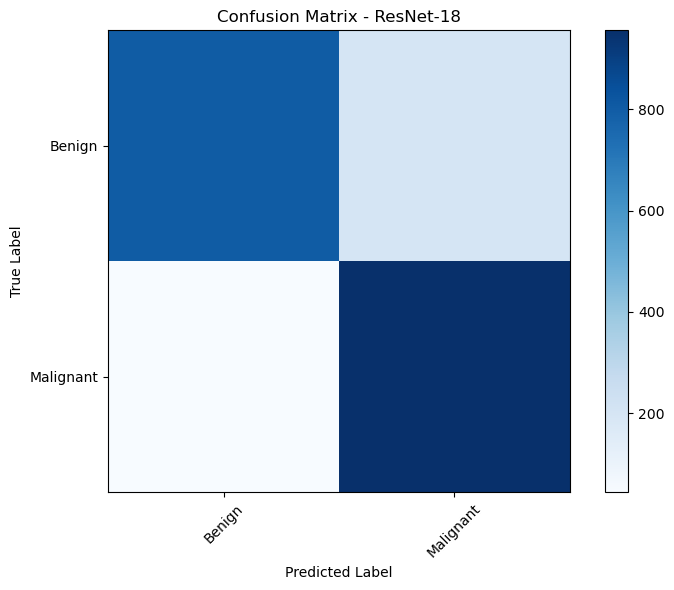

In [92]:
print("\nConfusion Matrix:")
cm = confusion_matrix(true_labels, predictions)
print(cm)

# plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix - {model_name}')
plt.colorbar()
tick_marks = np.arange(len(train_dataset.dataset.classes))
plt.xticks(tick_marks, train_dataset.dataset.classes, rotation=45)
plt.yticks(tick_marks, train_dataset.dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

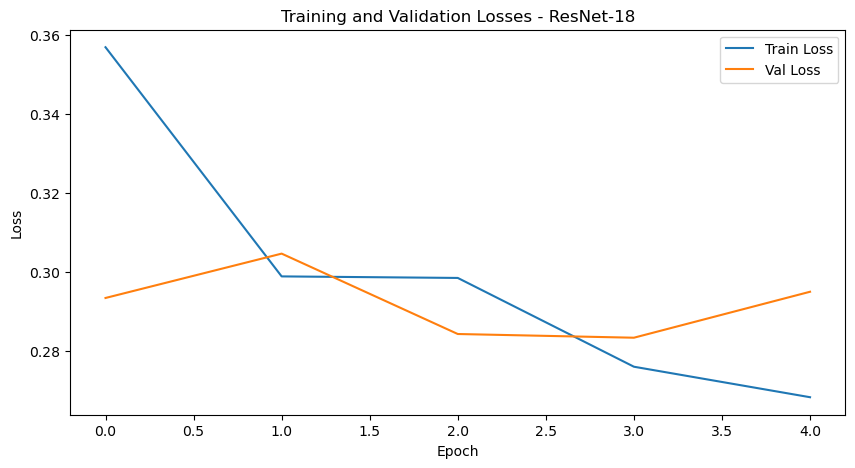

In [91]:
# plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title(f'Training and Validation Losses - {model_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()